# Import needed modules and useful functions

In [1]:
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':500000, #2.5ns of simulation
    'plumedseed':4525,
    'friction':10,
    'temp':1, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias/bias1_tica/"

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")

folder = "unbias/bias1_tica/"
execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias/bias1_tica/
Completed: plumed ves_md_linearexpansion input


## Trajectory 

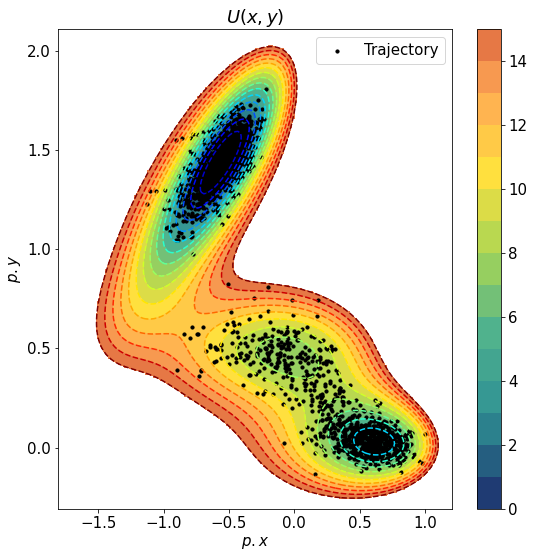

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values,load_dataframe(folder+"COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energy Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

In [5]:
x = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()
N = len(x)
x = x.reshape(N)
weight= np.exp(np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"])

In [6]:
average = np.average(x,weights=weight)
variance = np.cov(x,aweights=weight)
print("average: ",average, ", variance: ",variance)

average:  -0.4599190034197369 , variance:  0.12395322497499305


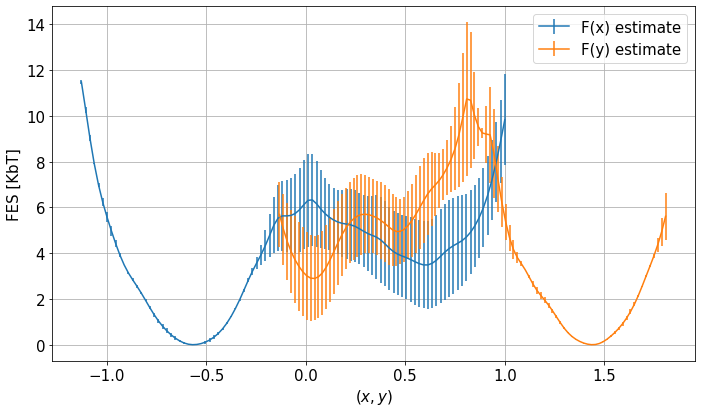

In [7]:
#-- estimation of Free Energy Surface 1D --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

In [8]:
#gridspec_fes(s,logweight,sim_parameters)

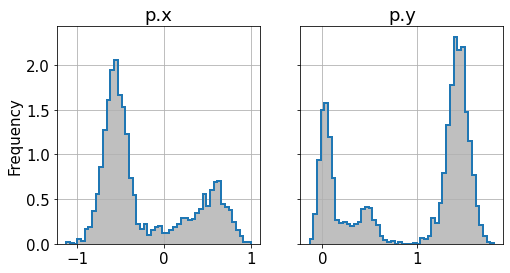

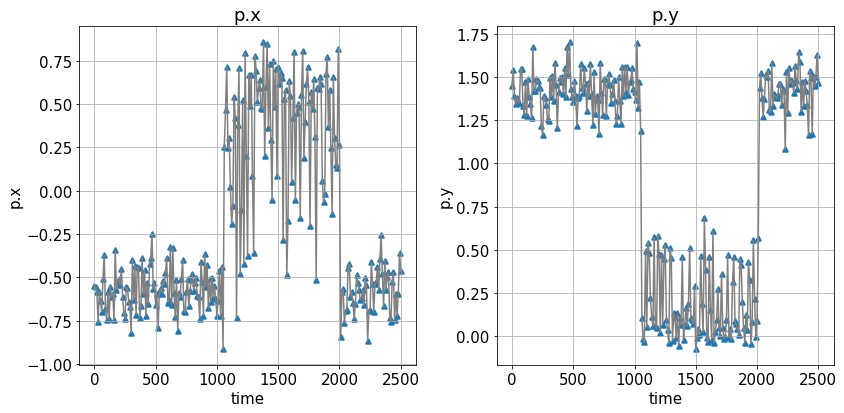

In [9]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

## DeepTICA Analysis and Export

In [10]:
data = load_dataframe(folder+"COLVAR")
size = len(data)
min_lag,max_lag = 1,5
n = 5 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^p').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2
n_input = len(descriptors_names)
train_parameters = {
              'descriptors': '^p', # can change during simulation
              'nodes':[n_input,10,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.8, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':100,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }
#--------------------------------------#

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values
# evaluate tprime
logweight = data["opes.bias"].to_numpy()/sim_parameters["temp"]
logweight -= max(logweight)
logweight /= np.abs(min(logweight))
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
#tprime = t

[1. 2. 3. 4. 5.]
training samples:  2000 	 validation samples 450


In [11]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset_new(X,t=t,lag_time=lag,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.0,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

NEW ALGORITHM IMPLEMENTATION
logweights are None
NEW ALGORITHM IMPLEMENTATION
logweights are None
NEW ALGORITHM IMPLEMENTATION
logweights are None
NEW ALGORITHM IMPLEMENTATION
logweights are None
NEW ALGORITHM IMPLEMENTATION
logweights are None
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.458      -1.474      0.981  0.249  
100   -1.466      -1.486      0.985  0.249  
150   -1.470      -1.492      0.987  0.250  
200   -1.472      -1.496      0.987  0.251  
250   -1.473      -1.498      0.987  0.252  
300   -1.474      -1.499      0.987  0.253  
350   -1.474      -1.499      0.987  0.253  
400   -1.474      -1.499      0.986  0.254  
INFO: Early stopping
410   -1.474      -1.499      0.986  0.254  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [12]:
#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

model saved
torch.float32
timescales:  [733.3054      7.2932143]
eigenvalues:  [0.9864557  0.25381804]


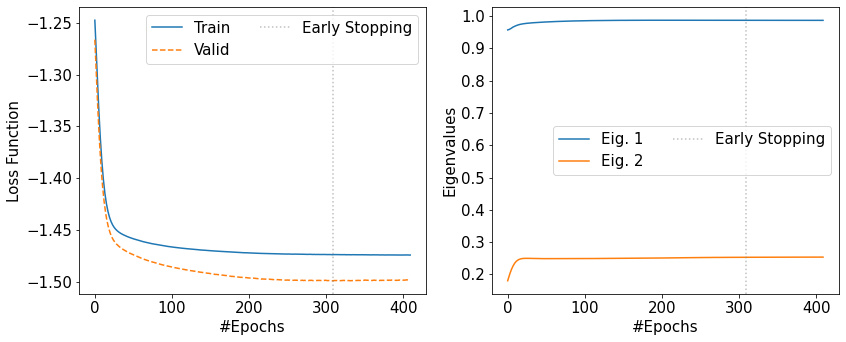

In [13]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [14]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

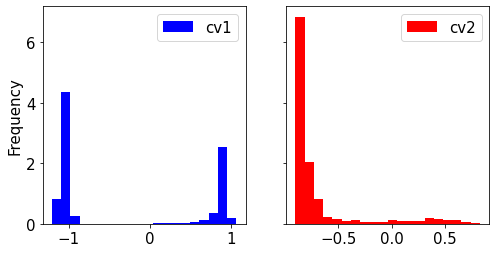

In [15]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

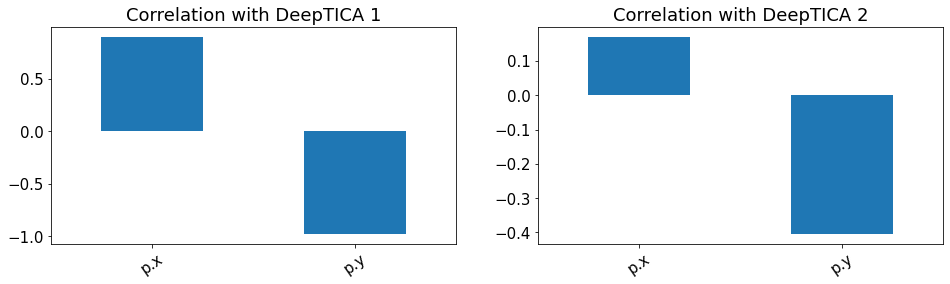

In [16]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from new cvs  

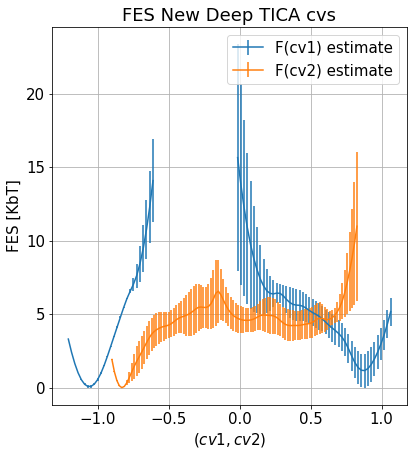

In [17]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Free Energy Estimation from sampled Deep-TICA Cvs

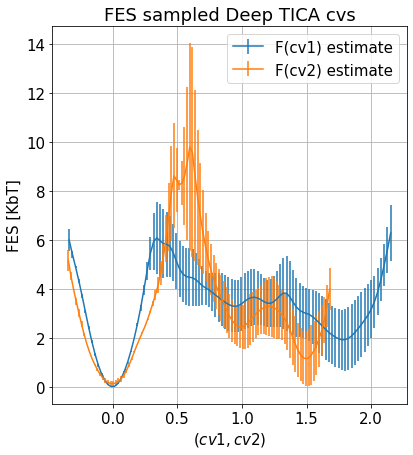

In [18]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^tica_cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES sampled Deep TICA cvs")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

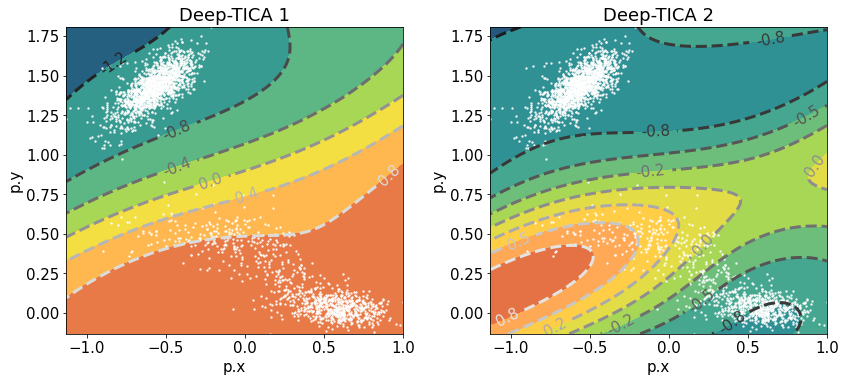

In [19]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

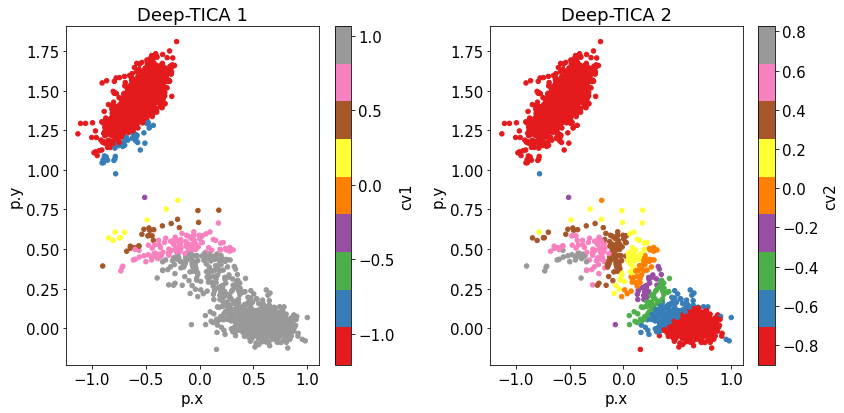

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

# TICA

In [21]:
data = load_dataframe(folder+"COLVAR")
t = data['time'].values
X = data[descriptors_names].values

# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)

TICA_CV()

In [22]:
# TRAIN
tica.fit(X, t, lag=min_lag)

#-- move the model back to cpu for convenience --# 
tica.to('cpu')
feature_names = data.filter(regex="p.*").columns.values
tica.set_params({"feature_names": feature_names})

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

eigenvalues:  [0.977281   0.21984419]


In [23]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[1] 

<AxesSubplot:ylabel='Frequency'>

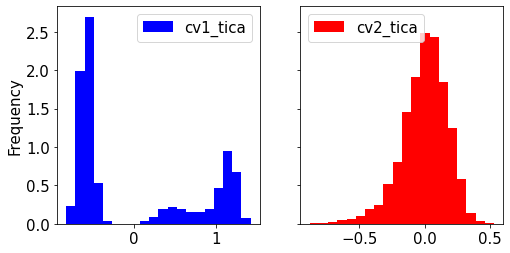

In [24]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2_tica",bins=20,ax=axs[1],density=True,color="r")

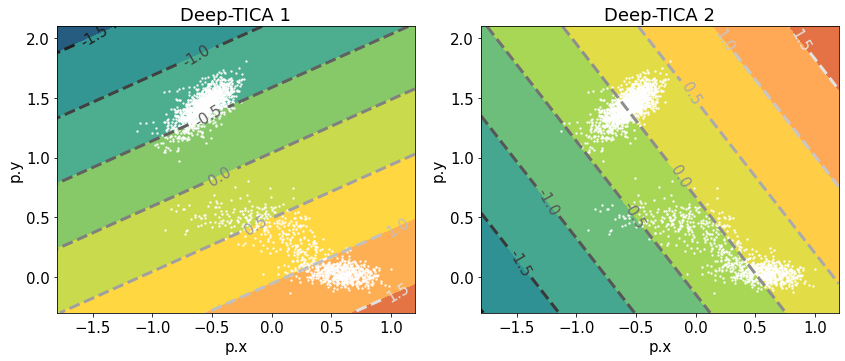

In [25]:
plot_cvs_isolines(tica,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)

## $\Delta F$ Estimate

Text(0.5, -0.03, 'shadow error of 0.5KbT')

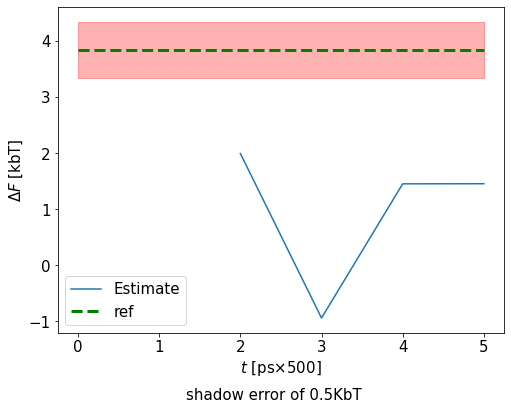

In [26]:
res = 3.841414368598573
#-- each step is 1ps --#
#-- we are interested in the first 50 ns --#
last = 1*1000*10#0 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]
#-- each step is 1ps --#
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    
    deltaf = np.append(deltaf,(sim_parameters["temp"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.grid()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [kbT]")
txt = "shadow error of 0.5KbT"
# center text
fig.text(.5, -.03, txt, ha='center')